In [41]:
import glob
import pathlib
from collections import Counter

import mne
import pywt

import scipy.stats
import numpy as np
import matplotlib.pyplot as plt

In [2]:
raw = mne.io.read_raw_edf("../data/edf/autism/Saud_Autism_1_5_2011S001R01.edf")
raw.rename_channels({"FP2": "Fp2"})
raw.set_montage("standard_1005")

print("Channels:", raw.ch_names)
raw

Extracting EDF parameters from /home/fahmi/research/eegautism/data/edf/autism/Saud_Autism_1_5_2011S001R01.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Channels: ['Fp1', 'F3', 'F7', 'T3', 'T5', 'O1', 'C4', 'Fp2', 'Fz', 'F4', 'F8', 'C3', 'Cz', 'Pz', 'Oz', 'O2']


Measurement date,"May 01, 2011 09:55:49 GMT"
Experimenter,Unknown
Participant,00000000
Digitized points,19 points
Good channels,16 EEG
Bad channels,None
EOG channels,Not available
ECG channels,Not available
Sampling frequency,256.02 Hz
Highpass,0.00 Hz
Lowpass,128.01 Hz


Effective window size : 7.999 (s)
Plotting power spectral density (dB=True).


/home/fahmi/research/eegautism/.venv/lib/python3.10/site-packages/mne/viz/utils.py:167: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  (fig or plt).show(**kwargs)


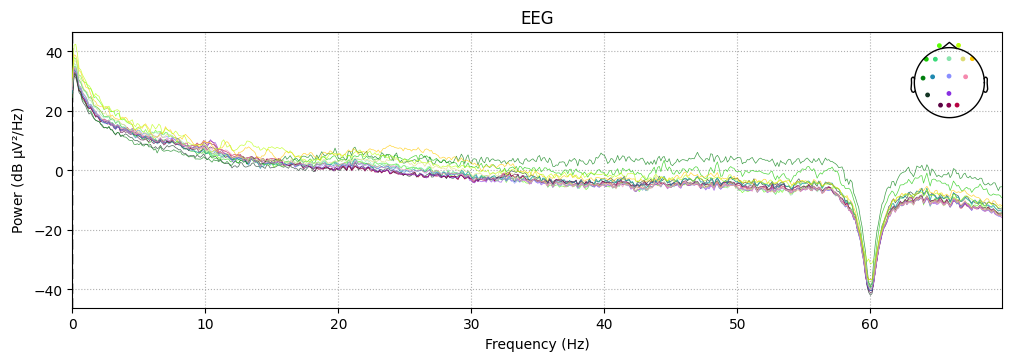

In [3]:
raw.compute_psd(fmax=70).plot(amplitude=False)
plt.show()

Using matplotlib as 2D backend.


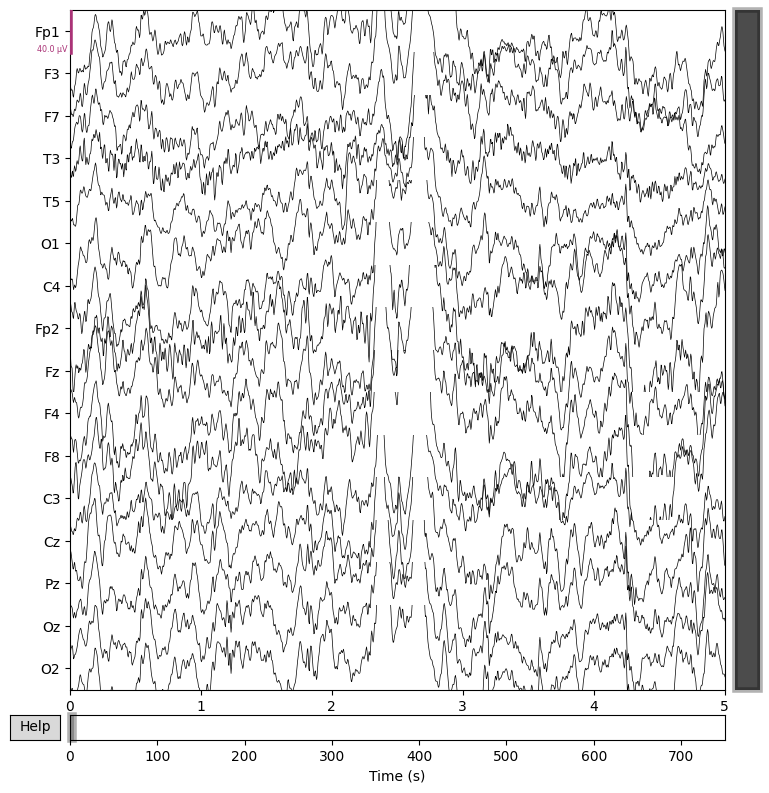

In [4]:
raw.plot(duration=5, n_channels=30)
plt.show()

## Preprocessing: ICA

In [5]:
ica = mne.preprocessing.ICA(n_components=10, random_state=97, max_iter=800)
ica.fit(raw)

Fitting ICA to data using 16 channels (please be patient, this may take a while)


/tmp/ipykernel_48524/2466710312.py:2: RuntimeWarning: The data has not been high-pass filtered. For good ICA performance, it should be high-pass filtered (e.g., with a 1.0 Hz lower bound) before fitting ICA.
  ica.fit(raw)


Selecting by number: 10 components
Fitting ICA took 1.9s.


Method,fastica
Fit parameters,algorithm=parallelfun=logcoshfun_args=Nonemax_iter=800
Fit,24 iterations on raw data (192096 samples)
ICA components,10
Available PCA components,16
Channel types,eeg
ICA components marked for exclusion,—


    Using multitaper spectrum estimation with 7 DPSS windows
Not setting metadata
375 matching events found
No baseline correction applied
0 projection items activated


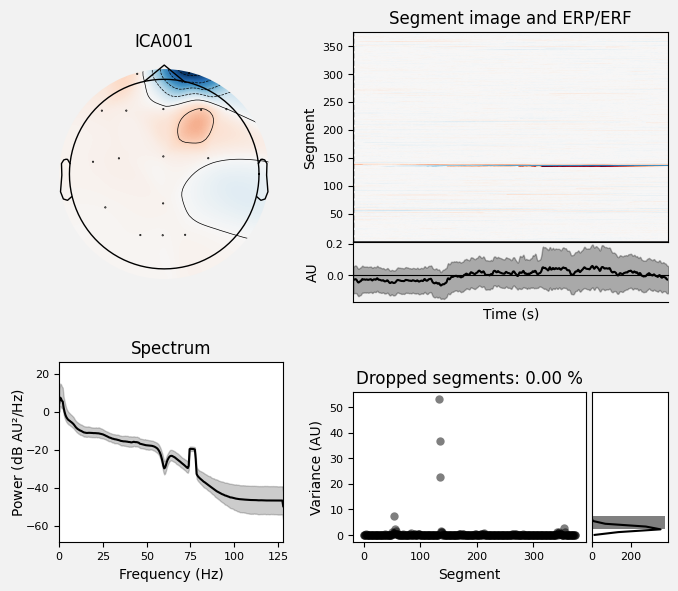

[<Figure size 700x600 with 6 Axes>]

In [6]:
ica.plot_properties(raw, picks=[1])

## Preprocessing: Continuous to Epochs

In [27]:
epochs = mne.make_fixed_length_epochs(raw, duration=60, preload=False)
epochs

Not setting metadata
12 matching events found
No baseline correction applied
0 projection items activated


Number of events,12
Events,1: 12
Time range,0.000 – 59.996 s
Baseline,off


Loading data for 12 events and 15361 original time points ...
0 bad epochs dropped
Not setting metadata
12 matching events found
No baseline correction applied
0 projection items activated


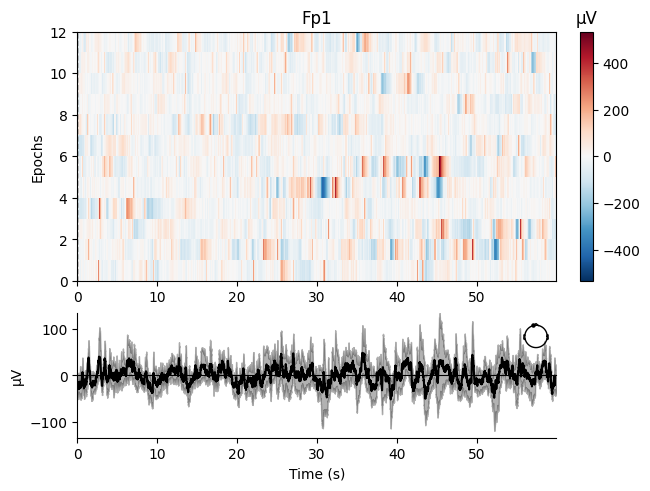

[<Figure size 640x480 with 4 Axes>]

In [28]:
epochs.plot_image(picks=["Fp1"])

No projector specified for this dataset. Please consider the method self.add_proj.


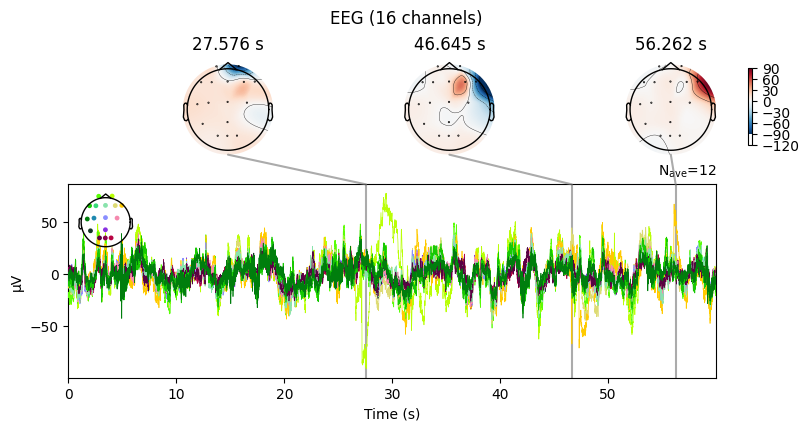

In [29]:
epochs.average().plot_joint(picks="eeg")
plt.show()

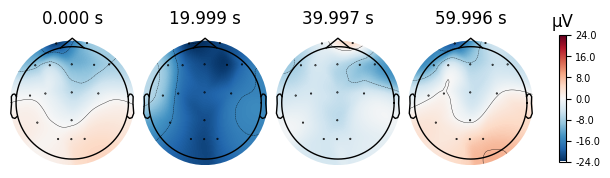

In [30]:
epochs.average().plot_topomap(ch_type="eeg")
plt.show()

## Preprocessing: Wavelet Transform

In [35]:
def calculate_statistics(list_values):
    mean = np.nanmean(list_values)
    std = np.nanstd(list_values)
    var = np.nanvar(list_values)
    skew = scipy.stats.skew(list_values)
    kurtosis = scipy.stats.kurtosis(list_values)

    return [mean, std, var, skew, kurtosis]

def calculate_entropy(list_values):
    counter_values = Counter(list_values).most_common()
    probabilities = [elem[1] / len(list_values) for elem in counter_values]
    entropy = scipy.stats.entropy(probabilities)

    return [entropy]

In [32]:
raw_signals = epochs.get_data()
dwt_signals = pywt.wavedec(raw_signals, "db4", level=4)

raw_signals.shape, len(dwt_signals)

Loading data for 12 events and 15361 original time points ...


5

## Classification using RF

In [63]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, RocCurveDisplay

In [67]:
X = []
y = []

for file in glob.glob("../data/edf/**/*.edf"):
    try:
        filepath = pathlib.Path(file)

        raw = mne.io.read_raw_edf(file)
        raw.rename_channels({"FP2": "Fp2"})
        raw.set_montage("standard_1005")

        epochs = mne.make_fixed_length_epochs(raw, duration=60, preload=False)
        segments = epochs.get_data()

        X.extend([segments[i, :, :] for i in range(segments.shape[0])])
        y.extend([filepath.parent.name] * segments.shape[0])
    except Exception as e:
        print("Failed to process", file, e)

X = np.array(X)
y = np.array(y)

np.unique(y, return_counts=True)

Extracting EDF parameters from /home/fahmi/research/eegautism/data/edf/normal/Amer_Normal_5_5_2011S001R03.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Not setting metadata
5 matching events found
No baseline correction applied
0 projection items activated
Loading data for 5 events and 15361 original time points ...
0 bad epochs dropped
Extracting EDF parameters from /home/fahmi/research/eegautism/data/edf/normal/Majdolin_Normal_18_5_2011S001R01.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Not setting metadata
15 matching events found
No baseline correction applied
0 projection items activated
Loading data for 15 events and 15361 original time points ...
0 bad epochs dropped
Extracting EDF parameters from /home/fahmi/research/eegautism/data/edf/normal/Mahmud_Normal_5_5_2011S001R01.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Not setting metadata
7 matchi

(array(['autism', 'normal'], dtype='<U6'), array([168,  83]))

In [68]:
X.shape

(251, 16, 15361)

In [69]:
# empty array for CWT results
X_dwt = []

# for each sample
for i in range(X.shape[0]):
    features = []

    # for each channel
    for j in range(X.shape[1]):
        # perform decomposition
        list_coeff = pywt.wavedec(X[i, j, :], "db4", level=4)
        for coeff in list_coeff:
            features += calculate_statistics(coeff)

    # append to list
    X_dwt.append(features)

X_dwt = np.array(X_dwt)

In [70]:
X_train, X_test, y_train, y_test = train_test_split(X_dwt, y, random_state=42, stratify=y)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((188, 400), (63, 400), (188,), (63,))

In [71]:
clf = RandomForestClassifier()
clf.fit(X_train, y_train)

RandomForestClassifier()

In [72]:
y_pred = clf.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

      autism       0.95      0.90      0.93        42
      normal       0.83      0.90      0.86        21

    accuracy                           0.90        63
   macro avg       0.89      0.90      0.90        63
weighted avg       0.91      0.90      0.91        63



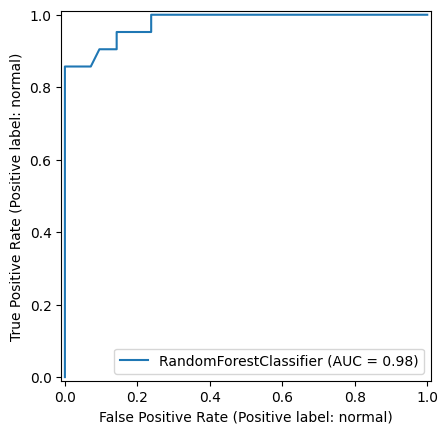

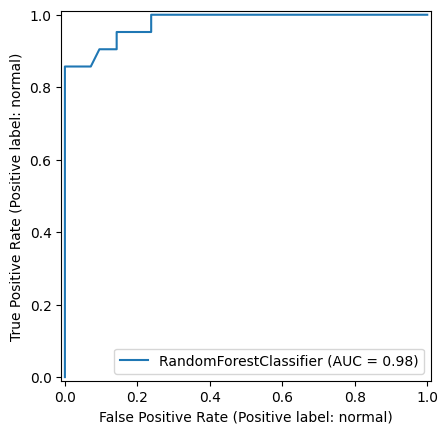

In [79]:
RocCurveDisplay.from_estimator(clf, X_test, y_test).plot()
plt.show()